# Binary Classification using Low-Approximate ConvNet Approach
In this jupyter notebook, we are trying to simplify the the complexity of ConvNet because of the growing number of paramemters requiring huge amounts of computerational resources. The goal of this final project is to create a code base for people to see the reduction of computation cost while still mainting ConvNet performance

## Importing data for training
In this section we need download a couple of things and upload it on to google drive.

Through this [link](http://shuoyang1213.me/WIDERFACE/) you will find a goole drive link for the following:

[WIDER_train.zip](https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view): WIDER Face Training Images

[WIDER_val.zip](https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view): WIDER FACE Validation Images

[wider_face_split](http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip): WIDER FACE annotations


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import zipfile
# import os

# # Replace this with your file location of WIDER_train.zip
# zip_file = "/content/drive/MyDrive/WIDERFACE Dataset/WIDER_train.zip"
# destination_folder = "/content/"
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# # Replace this with your file location of WIDER_val.zip
# zip_file = "/content/drive/MyDrive/WIDERFACE Dataset/WIDER_val.zip"
# destination_folder = "/content/"
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# # Replace this with your file location of wider_face_split.zip
# zip_file = "/content/drive/MyDrive/WIDERFACE Dataset/wider_face_split.zip"
# destination_folder = "/content/"
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# 1) WIDERFACE Dataset
In this section will format our data such that it is able to be used for WIDERFaceBinaryDataset class

## 1a) Importing libraries for WIDERFaceBinaryDataset Class

In [4]:
import os
import cv2
import random
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import random


## 1b) WIDERFaceBinaryDataset Class

Some things to note about the dataset class:

a) due to the fact in the annotations, there is something weird annotation issues with wider_face_train_bbx_gt.txt, I had to alter `_load_annotations` as well as `_crop_and_resize` to adjust for resizing the images to 32 x 36

b) Since the dataset uploaded was used originally for face detection, we have to alter the dataset for binary classification



In [5]:
class WIDERFaceBinaryDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None, img_size=(32, 36), neg_samples_per_img=5):
        self.image_dir = image_dir
        self.annotations = self._load_annotations(annotations_file)
        self.transform = transform
        self.img_size = img_size
        self.neg_samples_per_img = neg_samples_per_img
        self.data = self._prepare_data()

    def _load_annotations(self, annotations_file):
        annotations = {}
        with open(annotations_file, "r") as file:
            lines = file.readlines()
            idx = 0
            while idx < len(lines):
                image_path = lines[idx].strip()
                idx += 1

                if idx < len(lines):
                    try:
                        num_faces = int(lines[idx].strip())
                    except ValueError:
                        continue
                    idx += 1

                    bboxes = []
                    if num_faces > 0:
                        for _ in range(num_faces):
                            if idx < len(lines):
                                bbox_info = list(map(int, lines[idx].strip().split()[:4]))
                                if bbox_info[2] > 0 and bbox_info[3] > 0:
                                    bboxes.append(bbox_info)
                                idx += 1
                    annotations[image_path] = bboxes
        return annotations

    def _crop_and_resize(self, image, bbox):
        x, y, w, h = bbox
        height, width, _ = image.shape

        x = max(0, x)
        y = max(0, y)
        w = min(w, width - x)
        h = min(h, height - y)

        if w <= 0 or h <= 0:
            raise ValueError(f"Invalid bounding box with zero area: {bbox}")

        cropped = image[y:y + h, x:x + w]
        resized = cv2.resize(cropped, (36, 32))
        grayscale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        return grayscale

    def _generate_negative_samples(self, image, bboxes):
        neg_samples = []
        height, width, _ = image.shape
        for _ in range(self.neg_samples_per_img):
            while True:
                x = random.randint(0, width - self.img_size[0])
                y = random.randint(0, height - self.img_size[1])
                candidate_bbox = [x, y, self.img_size[0], self.img_size[1]]

                if not any(self._is_overlap(candidate_bbox, bb) for bb in bboxes):
                    cropped = image[y:y + self.img_size[1], x:x + self.img_size[0]]
                    resized = cv2.resize(cropped, self.img_size)
                    grayscale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
                    neg_samples.append(grayscale)
                    break
        return neg_samples

    def _is_overlap(self, box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        return not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1)

    def _prepare_data(self):
        """
        Flatten the dataset to return one sample (image, label) per index.
        """
        data = []
        for image_path, bboxes in self.annotations.items():
            # Load the image
            full_image_path = os.path.join(self.image_dir, image_path)
            image = cv2.imread(full_image_path)
            if image is None:
                continue

            # Add positive samples
            for bbox in bboxes:
                face = self._crop_and_resize(image, bbox)
                data.append((face, 1))  # Positive label: 1

            # Add negative samples
            negatives = self._generate_negative_samples(image, bboxes)
            for neg in negatives:
                data.append((neg, 0))  # Negative label: 0

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)

        # Ensure the image dimensions are consistent (Height × Width = 32 × 36)
        if image.shape[-2:] != (32, 36):
            image = image.permute(0, 2, 1)
        return image, label

## 1c) Visualizing Function to verify the dataset is sorting positive with negative faces

In [6]:
import matplotlib.pyplot as plt

def visualize_samples(dataset, num_samples=16):
    """
    Visualize positive and negative samples from the dataset.

    Args:
        dataset (WIDERFaceBinaryDataset): The dataset object.
        num_samples (int): Number of samples to visualize for each class.
    """
    positive_samples = []
    negative_samples = []

    # Separate positive and negative samples
    for image, label in dataset:
        if label == 1 and len(positive_samples) < num_samples:
            positive_samples.append(image)
        elif label == 0 and len(negative_samples) < num_samples:
            negative_samples.append(image)

        if len(positive_samples) >= num_samples and len(negative_samples) >= num_samples:
            break

    # Plot positive samples
    plt.figure(figsize=(12, 6))
    plt.suptitle("Positive Samples (Faces)", fontsize=16)
    for i, img in enumerate(positive_samples):
        plt.subplot(4, 4, i + 1)  # Adjust grid size for num_samples
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
        plt.imshow(img.squeeze(), cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Plot negative samples
    plt.figure(figsize=(12, 6))
    plt.suptitle("Negative Samples (Non-Faces)", fontsize=16)
    for i, img in enumerate(negative_samples):
        plt.subplot(4, 4, i + 1)  # Adjust grid size for num_samples
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
        plt.imshow(img.squeeze(), cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.tight_layout()
    plt.show()


## 1d) Counting the positive and negative samples

In [7]:
def count_samples(dataset):
    """
    Count the number of positive and negative samples in the dataset.

    Args:
        dataset (WIDERFaceBinaryDataset): The dataset object.

    Returns:
        dict: A dictionary with counts of positive and negative samples.
    """
    positive_count = 0
    negative_count = 0

    # Iterate through the dataset to count labels
    for _, label in dataset:
        if label == 1:
            positive_count += 1
        elif label == 0:
            negative_count += 1

    return {"positive": positive_count, "negative": negative_count}


## Looking at the dataset

Samples shape: torch.Size([1, 32, 36]), Labels: 1
Positive samples (faces): 159393
Negative samples (non-faces): 64400


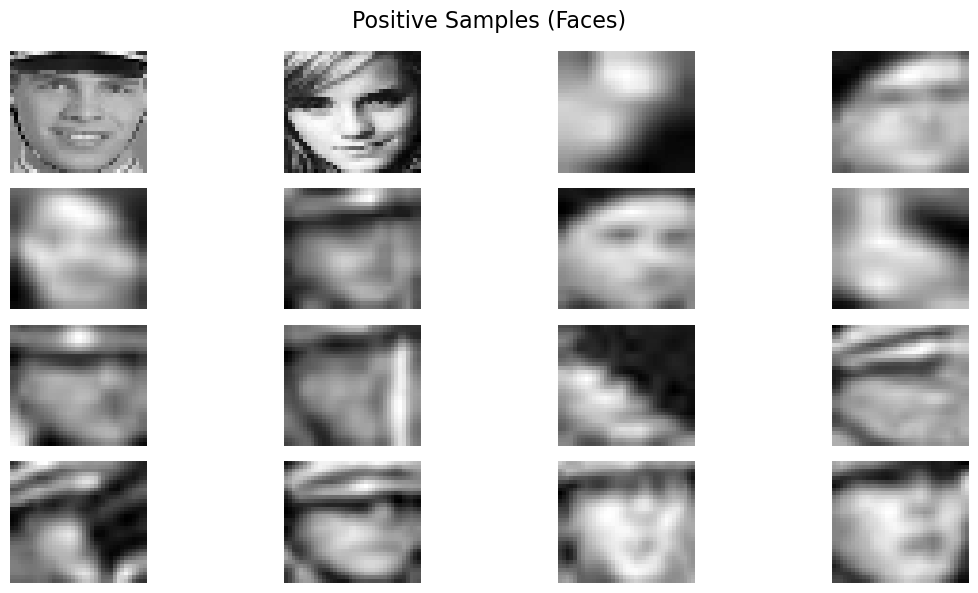

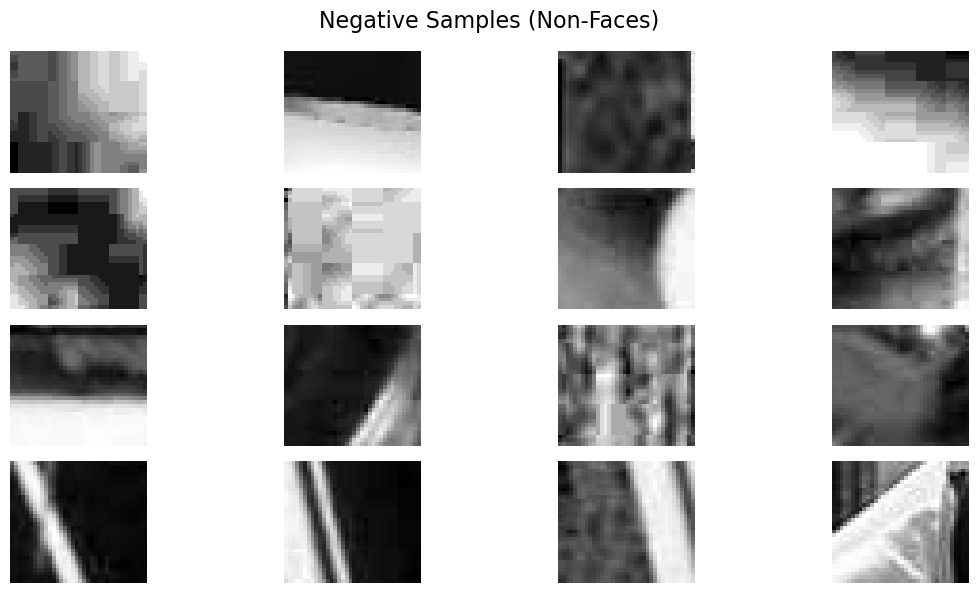

In [8]:
# Paths
image_dir = "WIDER_train/WIDER_train/images"
annotations_file = "wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt"

# Transformations
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Normalize if needed
])

# Create Dataset
dataset = WIDERFaceBinaryDataset(image_dir, annotations_file, transform=transform)

# Test a single sample
samples, labels = dataset[0]  # Get the first sample
print(f"Samples shape: {samples.shape}, Labels: {labels}")

sample_counts = count_samples(dataset)
print(f"Positive samples (faces): {sample_counts['positive']}")
print(f"Negative samples (non-faces): {sample_counts['negative']}")

# Visualize positive and negative samples
visualize_samples(dataset, num_samples=16)

# 2) Creating Model
In this section we aim to implement [4.1](https://arxiv.org/pdf/2208.00087) in the research paper. It is based on the[ Convolution Face Finder](https://ieeexplore.ieee.org/document/1335446). Before doing that, we must tackle the two things aimed to reduce the computational complexity of the neural network, the **convolutional filter** and the **activation functions**





## low-complexity approximate convolutional filters
We need to find approximate convolutional filter by solving for each
exact convolutional filter from a given ConvNet. This is done through the usage of **dyadic rationals**. These represent the weights of the convlutional filter, helping achieve low-complexity approximates.

Here we create a function to approximate convolutional filter weights using dyadic rationals in PyTorch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import time
import pandas as pd

In [10]:
def approximate_with_dyadic_rationals(tensor, max_b=1):
    """
    Approximate tensor values using dyadic rationals of the form a / 2^b.
    Here, max_b=1 applies D1 (a / 2^1) approximation.
    """
    flat_tensor = tensor.flatten()
    approximated = torch.zeros_like(flat_tensor)

    for i, value in enumerate(flat_tensor):
        value = value.item()  # Convert tensor value to scalar
        best_a, best_b = 0, 0
        best_diff = float("inf")

        for b in range(max_b + 1):
            a = round(value * (2 ** b))  # Perform rounding on scalar
            dyadic = a / (2 ** b)
            diff = abs(value - dyadic)
            if diff < best_diff:
                best_diff = diff
                best_a, best_b = a, b

        approximated[i] = best_a / (2 ** best_b)

    return approximated.view(tensor.shape)


In [11]:
def apply_dyadic_approximation(conv_layer, max_b=10):
    """
    Approximate the weights of a convolutional layer using dyadic rationals.
    """
    conv_layer.weight.data = approximate_with_dyadic_rationals(conv_layer.weight.data, max_b)
    if conv_layer.bias is not None:
        conv_layer.bias.data = approximate_with_dyadic_rationals(conv_layer.bias.data, max_b)
    return conv_layer

## Model Architecture
**Input Size**: 32 x 36 grayscale images
**Layers
*   Convolution + Average Pooling Layers
    * Layer 1: 4 filters of size 5 x 5  
    * Layer 2: 20 filters of size 3 x 3
    * Layer 3: 14 filters (fully connected convolution of size 6 x 7).
*   Output
    * Fully connected layer with 14 neurons followed by a single neuron for binary classification

**Approximate Activation Functions**
* continuous tanh-sigmoid function (our **exact**)
* Alippi and Storti-Gajani (ASG)
* Piecewise linear approximation of a non-linear function (PLAN)
* Simple Linear Functions
* Quadratic functions











## Table : Approximations for the tanh-sigmoid

| **Type**         | **Approximation**                                                                                                   |
|-------------------|--------------------------------------------------------------------------------------------------------------------|
| **ASG-based**    | $$
\sigma_1(x) = \hat{\alpha} \begin{cases}
-1 + \frac{1 + \frac{|x| - x}{2}}{2^{|x|}}, & x < 0, \\\\
1 - \frac{1 + \frac{|x| - x}{2}}{2^{|x|}}, & x \geq 0.
\end{cases}
$$|
| **PLAN-based**   | $$
\sigma_2(x) = \hat{\alpha} \begin{cases}
-1, & x < -5, \\\\
\frac{x}{16} - \frac{89}{128}, & -5 \leq x < -\frac{19}{8}, \\\\
\frac{x}{4}, & -\frac{19}{8} \leq x < -1, \\\\
\frac{x}{4} + \frac{1}{4}, & -1 \leq x < 1, \\\\
\frac{x}{16} + \frac{11}{16}, & 1 \leq x < \frac{19}{8}, \\\\
1, & x \geq 5.
\end{cases}
$$ |
| **Linear I**     | $$
\sigma_4(x) = \hat{\alpha} \begin{cases}
-1, & x < -2, \\\\
\frac{x}{2}, & -2 \leq x < 2, \\\\
1, & x \geq 2.
\end{cases}
$$ |
| **Linear II**    | $$
\sigma_4(x) = \hat{\alpha} \begin{cases}
-1, & x < -2, \\\\
\frac{x}{2}, & -2 \leq x < 2, \\\\
1, & x \geq 2.
\end{cases}
$$ |
| **Quadratic I**  | $$
\sigma_5(x) = \hat{\alpha} \begin{cases}
-1, & x < -4, \\\\
\left(\frac{x}{4} + 1\right)^2 - 1, & -4 \leq x < 0, \\\\
1 - \left(\frac{x}{4} - 1\right)^2, & 0 \leq x < 4, \\\\
1, & x \geq 4.
\end{cases}
$$ |
| **Quadratic II** | $$
\sigma_6(x) = \hat{\alpha} \begin{cases}
-1, & x < -2, \\\\
\left(\frac{x}{2} + 1\right)^2 - 1, & -2 \leq x < 0, \\\\
1 - \left(\frac{x}{2} - 1\right)^2, & 0 \leq x < 2, \\\\
1, & x \geq 2.
\end{cases}
$$ |

## Approximation activation functions implementation

In [12]:
# Define all activation functions
class ASGActivation(nn.Module):
    def __init__(self, a=7/4):
        super(ASGActivation, self).__init__()
        self.a = a

    def forward(self, x):
        abs_x = torch.abs(x)  # Compute |x|
        term = (abs_x - x) / (2 * self.a)  # Compute (|x| - x) / (2a)

        # Apply the piecewise function
        result = torch.where(x < 0, self.a * term, -self.a * term)
        return result

class PLANActivation(nn.Module):
    def forward(self, x):
        return torch.where(
            x < -5, -1,
            torch.where(
                x < -19/8, x / 16 - 89/128,
                torch.where(
                    x < -1, x / 4,
                    torch.where(
                        x < 1, x / 4 + 1/4,
                        torch.where(
                            x < 19/8, x / 16 + 11/16,
                            torch.where(x < 5, 1, 1)
                        )
                    )
                )
            )
        )

class LinearIActivation(nn.Module):
    def forward(self, x):
        return torch.where(
            x < -4, -1,
            torch.where(
                x < 4, x / 4,
                1
            )
        )

class LinearIIActivation(nn.Module):
    def forward(self, x):
        return torch.where(
            x < -2, -1,
            torch.where(
                x < 2, x / 2,
                1
            )
        )

class QuadraticIActivation(nn.Module):
    def forward(self, x):
        return torch.where(
            x < -4, -1,
            torch.where(
                x < 0, (x / 4 + 1)**2 - 1,
                torch.where(
                    x < 4, 1 - (x / 4 - 1)**2,
                    1
                )
            )
        )

class QuadraticIIActivation(nn.Module):
    def forward(self, x):
        return torch.where(
            x < -2, -1,
            torch.where(
                x < 0, (x / 2 + 1)**2 - 1,
                torch.where(
                    x < 2, 1 - (x / 2 - 1)**2,
                    1
                )
            )
        )

# Select activation function
def get_activation(name):
    if name == "asg":
        return ASGActivation()
    elif name == "plan":
        return PLANActivation()
    elif name == "linear_i":
        return LinearIActivation()
    elif name == "linear_ii":
        return LinearIIActivation()
    elif name == "quadratic_i":
        return QuadraticIActivation()
    elif name == "quadratic_ii":
        return QuadraticIIActivation()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unknown activation: {name}")

## CFF Model Implementation

In [13]:
# CFFBinaryClassifier
class CFFBinaryClassifier(nn.Module):
    def __init__(self, input_size=(32, 36), activation_name="tanh"):
        super(CFFBinaryClassifier, self).__init__()
        self.activation = get_activation(activation_name)

        # Layer 1: Convolution + Average Pooling
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Layer 2: Convolution + Average Pooling
        self.conv2 = nn.Conv2d(4, 20, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Placeholder for dynamically determined layers
        self.conv3 = None
        self.fc1 = None
        self.fc2 = nn.Linear(14, 1)

        # Dynamically configure the final layers
        self._configure_final_layers(input_size)

    def _configure_final_layers(self, input_size):
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, *input_size)
            dummy_output = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))

            h, w = dummy_output.shape[2], dummy_output.shape[3]
            self.conv3 = nn.Conv2d(20, 14, kernel_size=(h, w))
            self.fc1 = nn.Linear(14, 14)

    def forward(self, x):
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        x = self.activation(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 3) Training

## Data Preperation and spliting the data into training and validation set 8:2

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize

# Paths
annotations_file = "wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt"
image_dir = "WIDER_train/WIDER_train/images"

# Transformations
transform = Compose([
    ToTensor(),  # Convert NumPy array to PyTorch tensor
    Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Create the dataset
dataset = WIDERFaceBinaryDataset(image_dir, annotations_file, transform=transform)

# Split into training and validation datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/wider_face_split/wider_face_train_bbx_gt.txt'

## Training Function
change the number of epochs in the function here

In [ ]:
# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device="cuda"):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


## Evaluation Functions

In [ ]:
# Evaluation Function
def evaluate_average_precision(model, data_loader, device="cuda"):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = outputs.squeeze()

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    ap_score = average_precision_score(all_labels, all_probs)
    return ap_score

In [ ]:
# Evaluate all activation functions
def evaluate_activations_for_configurations(train_loader, test_loader, activation_names, configurations, device="cpu"):
    results = []
    runtimes = []

    for config_name, max_b_values in configurations.items():
        print(f"\nEvaluating configuration: {config_name}")

        for activation_name in activation_names:
            print(f"  Activation: {activation_name}")
            model = CFFBinaryClassifier(activation_name=activation_name).to(device)

            # Loss and optimizer
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # Train the model and measure runtime
            start_time = time.time()
            train_model(model, train_loader, criterion, optimizer, num_epochs=5, device=device)
            end_time = time.time()
            runtime = end_time - start_time

            # Apply dyadic rational approximation
            model.conv1 = apply_dyadic_approximation(model.conv1, max_b=max_b_values.get("conv1", 1))
            model.conv2 = apply_dyadic_approximation(model.conv2, max_b=max_b_values.get("conv2", 1))
            model.conv3 = apply_dyadic_approximation(model.conv3, max_b=max_b_values.get("conv3", 1))

            # Evaluate the model
            ap_score = evaluate_average_precision(model, test_loader, device=device)

            # Collect results
            results.append({"configuration": config_name, "activation": activation_name, "average_precision": ap_score})
            runtimes.append({"configuration": config_name, "activation": activation_name, "runtime_minutes": int(runtime // 60), "runtime_seconds": int(runtime % 60)})

    return pd.DataFrame(results), pd.DataFrame(runtimes)

## Training Loop
Here you can choose which activation functions you would like to use as well as manipulate the convolution layers using a specific dyadic set.

In [ ]:
import pandas as pd
activation_names = ["tanh", "asg", "plan", "linear_i", "linear_ii", "quadratic_i", "quadratic_ii"]
activation_names = ["asg"]
configurations = {
        "A_1": {"conv1": 1, "conv2": 1, "conv3": 1},
        "A_2": {"conv1": 2, "conv2": 2, "conv3": 2},
        "A_3": {"conv1": 3, "conv2": 3, "conv3": 3},
        "A_4": {"conv1": 4, "conv2": 4, "conv3": 4},
        "A_5": {"conv1": 5, "conv2": 5, "conv3": 5},
        "A_6": {"conv1": 6, "conv2": 6, "conv3": 6},
        "A_7": {"conv1": 7, "conv2": 7, "conv3": 7},
        "A_8": {"conv1": 8, "conv2": 8, "conv3": 8},
        "A_7_3_3": {"conv1": 7, "conv2": 3, "conv3": 3},
        "A_7_4_4": {"conv1": 7, "conv2": 4, "conv3": 4},
        "A_7_6_6": {"conv1": 7, "conv2": 6, "conv3": 6},
        # Add more configurations as needed
    }
# Evaluate and print results
ap_df, runtime_df = evaluate_activations_for_configurations(train_loader, val_loader,
                                                            activation_names, configurations,
                                                            device="cpu")
print("\nAverage Precision Scores:")
print(ap_df)
print("\nRuntime (minutes:seconds):")
print(runtime_df)

# Save results to CSV
ap_df.to_csv("average_precision_results.csv", index=False)
runtime_df.to_csv("runtime_results.csv", index=False)



NameError: name 'evaluate_activations_for_configurations' is not defined

Things to do tmr:
run this program in its entirety